In [1]:
import galsim
import numpy as np

import ultraplot as uplot

## Spergel HLR

In [2]:
nu_vals = np.linspace(-0.85, 4.0, 500)
NU_FRAC = 0.5

frac_vals = []
for nu in nu_vals:
    prof = galsim.Spergel(nu, scale_radius=1)
    frac_vals.append(prof.calculateFluxRadius(NU_FRAC))
    
frac_vals = np.array(frac_vals)

<a list of 1 Line2D objects>

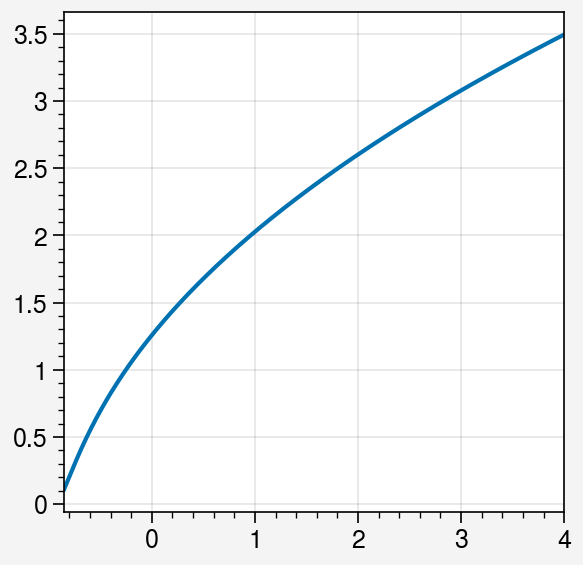

In [3]:
fig, axs = uplot.subplots()

axs.plot(nu_vals, frac_vals)

In [4]:
import scipy.optimize
import numpy.polynomial
from numpy.polynomial import Polynomial

numpy.polynomial.set_default_printstyle("ascii")

In [5]:
RATNL_ORDER = 9

def get_ratnl_func_polys(coeff):
    p_coeff = coeff[0:RATNL_ORDER+1]
    q_coeff = np.concatenate([[1], coeff[RATNL_ORDER+1:]])
    pm = Polynomial(p_coeff)
    qm = Polynomial(q_coeff)
    return pm, qm
    

def ratnl_func(x, *coeff):
    pm, qm = get_ratnl_func_polys(coeff)
    return pm(x) / qm(x)


res = scipy.optimize.curve_fit(ratnl_func, nu_vals, frac_vals, p0=np.ones(2*RATNL_ORDER + 1), full_output=True)

In [6]:
coeff = res[0]

pm, qm =  get_ratnl_func_polys(coeff)

In [7]:
def make_poly_code(pm, head="", base_indent=0):
    res = ""
    indent = base_indent
    for c in pm.coef:
        if c == pm.coef[-1]:
            end = ""
        else:
            end = " + x * ("

        if c == pm.coef[0]:
            _hd = head
        else:
            _hd = ""
        res += " " * 4*indent + f"{_hd}{c}{end}\n"
        if c != pm.coef[-1]:
            indent += 1

    for _ in pm.coef[:-1]:
        indent -= 1
        res += " " * 4*indent + ")\n"

    return res


code = "def _spergel_hlr(x):\n"
code += make_poly_code(pm, head="pm = ", base_indent=1)
code += make_poly_code(qm, head="qm = ", base_indent=1)
code += "    return pm / qm"

print(code)

def _spergel_hlr(x):
    pm = 1.2571513771129166 + x * (
        3.7059053890269102 + x * (
            2.8577090425861944 + x * (
                -0.30570486567039273 + x * (
                    0.6589831675940833 + x * (
                        3.375577680133867 + x * (
                            2.8143565844741403 + x * (
                                0.9292378858457211 + x * (
                                    0.12096941981286179 + x * (
                                        0.004206502758293099
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
    qm = 1.0 + x * (
        2.1939178810491837 + x * (
            0.8281034080784796 + x * (
                -0.5163329765186994 + x * (
                    0.9164871490929886 + x * (
                        1.8988551389326231 + x * (
                            1.042688817291684 + x * (

9.072944411797624e-09 6.270160715637907e-08
9.072944411797624e-09 6.270160715637907e-08


<a list of 1 Line2D objects>

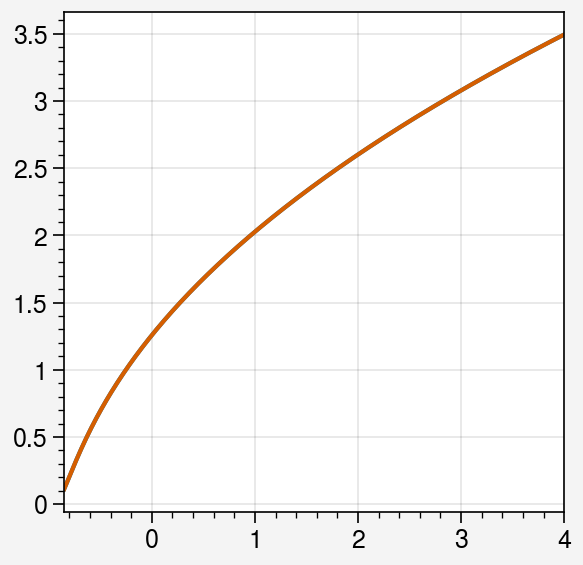

In [8]:
exec(code)

preds = _spergel_hlr(nu_vals)
diff = np.abs(frac_vals - preds)
print(np.mean(diff), np.max(diff))

preds = ratnl_func(nu_vals, *coeff)
diff = np.abs(frac_vals - preds)
print(np.mean(diff), np.max(diff))


fig, axs = uplot.subplots()

# axs.plot(nu_vals, hlr_vals)
axs.plot(nu_vals, frac_vals)
axs.plot(nu_vals, preds)

In [9]:
rng = np.random.RandomState()

diffs = []
nus = []
for _ in range(10000):
    nu = rng.uniform(low=-0.85, high=4.0)
    re = 1.0

    try:
        ival = _spergel_hlr(nu)
        tval = galsim.Spergel(nu, scale_radius=re).calculateFluxRadius(NU_FRAC)
    except Exception:
        pass
    else:
        diffs.append(ival - tval)
        nus.append(nu)

print(np.median(np.abs(diffs)), np.max(np.abs(diffs)), nus[np.argmax(np.abs(diffs))])

9.079122786914695e-09 6.302919142164853e-08 -0.8412399010431769


# CODE NOT USED BELOW HERE

## Try rad at fixed nu

In [ ]:
NU = 0.5

n_pts = 500
n_log = 200
n_mid = n_pts - 2 * n_log
frac_cut = 0.4
frac_min = 1e-8
eps = 1e-12
logfracs = np.logspace(np.log10(frac_min), np.log10(frac_cut), n_log)
frac_vals = np.concatenate([
    logfracs, 
    np.linspace(frac_cut + eps, 0.5 + np.abs(0.5 - frac_cut) - 2 * eps, n_mid), 
    1.0 - logfracs[::-1] - eps,
])

prof = galsim.Spergel(NU, scale_radius=1)
rad_vals = []
for frac in frac_vals:
    rad_vals.append(prof.calculateFluxRadius(frac))
    
rad_vals = np.array(rad_vals)

In [ ]:
fig, axs = uplot.subplots()

axs.plot(np.log(frac_vals), np.log(rad_vals))

In [ ]:
import scipy.optimize
import numpy.polynomial
from numpy.polynomial import Polynomial

numpy.polynomial.set_default_printstyle("ascii")

In [ ]:
RATNL_ORDER = 7

def get_ratnl_func_polys(coeff):
    p_coeff = coeff[0:RATNL_ORDER+1]
    q_coeff = np.concatenate([[1], coeff[RATNL_ORDER+1:]])
    pm = Polynomial(p_coeff)
    qm = Polynomial(q_coeff)
    return pm, qm
    

def ratnl_func(x, *coeff):
    pm, qm = get_ratnl_func_polys(coeff)
    return pm(x) / qm(x)


res = scipy.optimize.curve_fit(
    ratnl_func, 
    np.log(frac_vals), 
    np.log(rad_vals), 
    p0=np.ones(2*RATNL_ORDER + 1), 
    full_output=True,
    maxfev=100000,
)
print(res[-2])

In [ ]:
coeff = res[0]

pm, qm =  get_ratnl_func_polys(coeff)

In [ ]:
rng = np.random.RandomState()

diffs = []
fracs = []
for _ in range(10000):
    frac = rng.uniform(low=frac_min, high=1.0 - frac_min - eps)
    re = 1.0

    try:
        ival = ratnl_func(np.log(frac), *coeff)
        tval = np.log(galsim.Spergel(NU, scale_radius=re).calculateFluxRadius(frac))
    except Exception:
        pass
    else:
        diffs.append(ival - tval)
        fracs.append(frac)

print(np.median(np.abs(diffs)), np.max(np.abs(diffs)), (fracs[np.argmax(np.abs(diffs))]))

In [ ]:

fig, axs = uplot.subplots()

axs.plot(np.log(frac_vals), ratnl_func(np.log(frac_vals), *coeff) - np.log(rad_vals))
# axs.plot(np.log(frac_vals), )

## Try Full Flux Radius Computation w/ Polynomial Product

In [ ]:
RATNL_ORDER = 5
n_params = 2 * (RATNL_ORDER + 1) + 2 * RATNL_ORDER


def get_ratnl_func_polys(coeff):
    n_p = RATNL_ORDER+1
    n_q = RATNL_ORDER
    p_coeff = coeff[0:n_p]
    q_coeff = np.concatenate([[1], coeff[n_p:n_p+n_q]])
    pm = Polynomial(p_coeff)
    qm = Polynomial(q_coeff)

    n_p = RATNL_ORDER+1
    n_q = RATNL_ORDER
    p_coeff = coeff[n_p + n_q:n_p + n_q + n_p]
    q_coeff = np.concatenate([[1], coeff[n_p + n_q + n_p:]])
    pm2 = Polynomial(p_coeff)
    qm2 = Polynomial(q_coeff)    
    
    return pm, qm, pm2, qm2
    

def ratnl_func(x, *coeff):
    pm, qm, pm2, qm2 = get_ratnl_func_polys(coeff)
    return pm(x[0, :]) / qm(x[0, :]) * pm2(x[1, :]) / qm2(x[1, :])


n_pts = 500
n_log = 200
n_mid = n_pts - 2 * n_log
frac_cut = 0.4
frac_min = 1e-8
eps = 1e-12
logfracs = np.logspace(np.log10(frac_min), np.log10(frac_cut), n_log)
fracs = np.concatenate([
    logfracs, 
    np.linspace(frac_cut + eps, 0.5 + np.abs(0.5 - frac_cut) - 2 * eps, n_mid), 
    1.0 - logfracs[::-1] - eps,
])
nu_vals = np.linspace(-0.0, 0.01, n_pts)

rad_vals = []
x_vals = []
for nu in nu_vals:
    for frac in fracs:
        try:
            rad_vals.append(galsim.Spergel(nu, scale_radius=1).calculateFluxRadius(frac))
        except Exception:
            rad_vals.append(np.nan)
        x_vals.append([nu, np.log(frac)])
rad_vals = np.array(rad_vals)
x_vals = np.array(x_vals).T

msk = np.isfinite(rad_vals)
rad_vals = np.log(rad_vals[msk])
x_vals = x_vals[:, msk]

print(x_vals.shape, x_vals[0, 0:10], x_vals[1, 0:10])

In [ ]:
eps = 1e-6
res = scipy.optimize.curve_fit(
    ratnl_func, x_vals, rad_vals, p0=np.ones(n_params), full_output=True,
    maxfev=1000000,
    ftol=eps,
    xtol=eps,
)

In [ ]:
coeff = res[0]

pred = ratnl_func(x_vals, *coeff)
diff = np.abs(rad_vals - pred)

print(np.median(diff), np.max(diff))

In [ ]:
nu_vals = np.linspace(-0.85, 4.0, 500)
NU_FRAC = 0.005

frac_vals = []
ifrac_vals = []
for nu in nu_vals:
    prof = galsim.Spergel(nu, scale_radius=1)
    frac_vals.append(prof.calculateFluxRadius(NU_FRAC))
    xvals = np.array([[nu, np.log(NU_FRAC)]]).T
    ifrac_vals.append(np.exp(ratnl_func(xvals, *coeff)))
    
frac_vals = np.array(frac_vals)
ifrac_vals = np.array(ifrac_vals)

fig, axs = uplot.subplots()

axs.plot(nu_vals, frac_vals)
axs.plot(nu_vals, ifrac_vals)

## Try full Flux Radius computation

In [ ]:
from numba import njit

NU_FRAC_ORDER = 3
NU_FRAC_ORDER_PLUS_ONE = NU_FRAC_ORDER + 1
n_params = 2 * (NU_FRAC_ORDER_PLUS_ONE * (NU_FRAC_ORDER_PLUS_ONE + 1) // 2) - 1


@njit
def compute_poly_matrix_from_coeff(coeff):
    n_per = (NU_FRAC_ORDER_PLUS_ONE * (NU_FRAC_ORDER_PLUS_ONE + 1) // 2)
    p_coeff = coeff[:n_per]
    q_coeff = np.zeros(n_per) # p_coeff.copy()
    q_coeff[0] = 1.0
    q_coeff[1:] = coeff[n_per:]
    
    loc = 0
    c_p = np.zeros((NU_FRAC_ORDER_PLUS_ONE, NU_FRAC_ORDER_PLUS_ONE))
    c_q = np.zeros((NU_FRAC_ORDER_PLUS_ONE, NU_FRAC_ORDER_PLUS_ONE))
    for i in range(NU_FRAC_ORDER_PLUS_ONE):
        for j in range(NU_FRAC_ORDER_PLUS_ONE):
            if i + j <= NU_FRAC_ORDER:
                c_p[i, j] = p_coeff[loc]
                c_q[i, j] = q_coeff[loc]
                loc += 1
    return c_p, c_q

@njit
def ratnl_func(nu_frac, *coeff):
    nu, frac = nu_frac[0, :], nu_frac[1, :]
    c_p, c_q = compute_poly_matrix_from_coeff(np.array(coeff))
    return (
        numpy.polynomial.polynomial.polyval2d(nu, frac, c_p) 
        / numpy.polynomial.polynomial.polyval2d(nu, frac, c_q)
    )

n_pts = 500
n_log = 150
n_mid = n_pts - 2 * n_log
frac_cut = 0.4
frac_min = 1e-8
eps = 1e-12
logfracs = np.logspace(np.log10(frac_min), np.log10(frac_cut), n_log)
fracs = np.concatenate([
    logfracs, 
    np.linspace(frac_cut + eps, 0.5 + np.abs(0.5 - frac_cut) - 2 * eps, n_mid), 
    1.0 - logfracs[::-1] - eps,
])
nu_vals = np.linspace(-0.85, 4.0, n_pts)

rad_vals = []
x_vals = []
for nu in nu_vals:
    for frac in fracs:
        try:
            rad_vals.append(galsim.Spergel(nu, scale_radius=1).calculateFluxRadius(frac))
        except Exception:
            rad_vals.append(np.nan)
        x_vals.append([nu, np.log(frac)])
rad_vals = np.array(rad_vals)
x_vals = np.array(x_vals).T


msk = np.isfinite(rad_vals)
rad_vals = rad_vals[msk]
x_vals = x_vals[:, msk]

In [ ]:
tol = 1e-2
res = scipy.optimize.curve_fit(
    ratnl_func, x_vals, np.log(rad_vals), p0=np.ones(n_params), full_output=True,
    xtol=tol, ftol=tol, maxfev=100000
    
)
res[-2]

In [ ]:
coeff = res[0]

pred = ratnl_func(x_vals, *coeff)
diff = np.abs(np.log(rad_vals) - pred)

print(np.median(diff), np.max(diff))

In [ ]:
nu_vals = np.linspace(-0.85, 4.0, 500)
NU_FRAC = 0.9

frac_vals = []
ifrac_vals = []
for nu in nu_vals:
    prof = galsim.Spergel(nu, scale_radius=1)
    frac_vals.append(prof.calculateFluxRadius(NU_FRAC))
    xvals = np.array([[nu, np.log(NU_FRAC)]]).T
    ifrac_vals.append(np.exp(ratnl_func(xvals, *coeff)))
    
frac_vals = np.array(frac_vals)
ifrac_vals = np.array(ifrac_vals)

fig, axs = uplot.subplots()

axs.plot(nu_vals, frac_vals)
axs.plot(nu_vals, ifrac_vals)